In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
import optuna
import lightgbm as lgb
from imblearn.pipeline import Pipeline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [2]:
df = pd.read_csv('churn-bigml-80.csv')
df_test = pd.read_csv('churn-bigml-20.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

In [3]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of Features: {df.shape[1]}')
print(f'Number of null values: {df.isnull().sum().values.sum()}')

Number of rows: 2666
Number of Features: 20
Number of null values: 0


### Classifying Churn into Voluntary & Involuntary

In [5]:
# Create a new column for churn type
df['Churn_Type'] = 'Unknown'  # Default

# Rule 1: High customer service calls → Voluntary churn
df.loc[(df['Churn'] == True) & (df['Customer service calls'] > df['Customer service calls'].median()), 'Churn_Type'] = 'Voluntary'

# Rule 2: High usage but churned → Voluntary churn (price-sensitive)
df.loc[(df['Churn'] == True) & (df['Total day minutes'] > df['Total day minutes'].median()), 'Churn_Type'] = 'Voluntary'

# Rule 3: Short account length and churned → Involuntary churn (new user dropout)
df.loc[(df['Churn'] == True) & (df['Account length'] < df['Account length'].median()), 'Churn_Type'] = 'Involuntary'

# Rule 4: Very low usage (inactive customers) → Involuntary churn
df.loc[(df['Churn'] == True) & (df['Total day minutes'] < df['Total day minutes'].median()) & (df['Total eve minutes'] < df['Total eve minutes'].median()), 'Churn_Type'] = 'Involuntary'

# Display churn type distribution
print(df['Churn_Type'].value_counts(normalize=True))


Churn_Type
Unknown        0.858215
Involuntary    0.088897
Voluntary      0.052888
Name: proportion, dtype: float64


##### 🔹 Churn Classification Conclusion
Our analysis classified churn into **Voluntary, Involuntary, and Unknown types** based on customer service calls, usage patterns, and account length. However, **85.82% of churn cases remain "Unknown"**, indicating that our dataset lacks critical features like **billing failures, customer satisfaction scores, or competitor influence**. 

This suggests that churn in this dataset is driven by **multiple overlapping factors** rather than a single cause. Future analysis should focus on **gathering additional customer insights, payment history, and competitor impact data** to better classify churn and create more targeted retention strategies.


### Segment Customers by Value & Payment Type

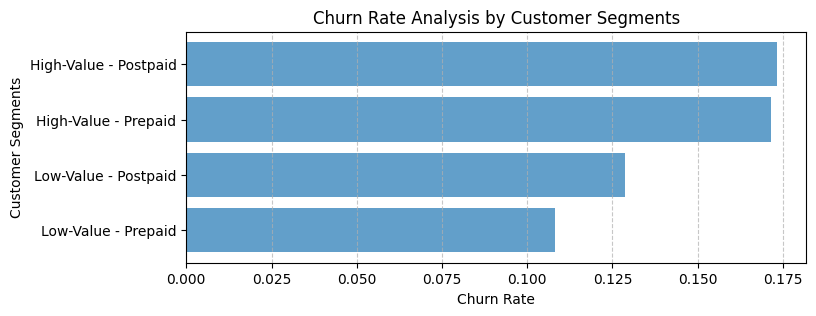

Total number of high value customers: 1340
Total number of High_value Post paid customers: 664


,High_Value_Customer,Postpaid_Customer,Churn_Rate
0,Low-Value,Prepaid,0.108271
1,Low-Value,Postpaid,0.128593
2,High-Value,Prepaid,0.171598
3,High-Value,Postpaid,0.173193


In [ ]:
# Step 1: Define High-Value vs. Low-Value Customers
usage_features = [
    'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes',
    'Total day charge', 'Total eve charge', 'Total intl charge'
]

median_values = df[usage_features].median()
df['High_Value_Customer'] = df[usage_features].sum(axis=1) > median_values.sum()

# Step 2: Define Postpaid vs. Prepaid Customers based on Account Length
account_length_median = df['Account length'].median()
df['Postpaid_Customer'] = df['Account length'] > account_length_median

# Step 3: Compute Churn Rates for Each Segment
churn_rates = df.groupby(['High_Value_Customer', 'Postpaid_Customer'])['Churn'].mean().reset_index()
churn_rates.columns = ['High_Value_Customer', 'Postpaid_Customer', 'Churn_Rate']

# Convert boolean values to readable labels
churn_rates['High_Value_Customer'] = churn_rates['High_Value_Customer'].map({True: 'High-Value', False: 'Low-Value'})
churn_rates['Postpaid_Customer'] = churn_rates['Postpaid_Customer'].map({True: 'Postpaid', False: 'Prepaid'})


plt.figure(figsize=(8, 3))
plt.barh(
    churn_rates.apply(lambda x: f"{x['High_Value_Customer']} - {x['Postpaid_Customer']}", axis=1),
    churn_rates['Churn_Rate'],
    alpha=0.7
)
plt.xlabel("Churn Rate")
plt.ylabel("Customer Segments")
plt.title("Churn Rate Analysis by Customer Segments")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
counts = df.groupby('Postpaid_Customer')['High_Value_Customer'].sum()[True]
N_High_value = df['High_Value_Customer'].sum()
print(f'Total number of high value customers: {N_High_value}')
print(f'Total number of High_value Post paid customers: {counts}')


churn_rates


#### 🔹 Conclusion
High-value customers have **higher churn rates (~17%)** compared to low-value customers (~10-12%), suggesting they may have **higher expectations or better alternatives**. Additionally, **postpaid and prepaid customers have nearly equal churn rates**, indicating that dissatisfaction with contracts, pricing, or service quality affects both segments equally. Retention efforts should focus on **identifying key churn drivers**—such as **customer service issues, pricing concerns, or plan benefits**—to improve customer loyalty across both prepaid and postpaid users.


### Identification of Key Drivers of Churn

#### Checking for Multicollinearity Using Variance Inflation Factor (VIF)

Before selecting the best model or method for feature selection, we need to check for **multicollinearity** in our features.  
Multicollinearity occurs when one feature is highly correlated with another, which can distort the importance of individual features.  

We use **Variance Inflation Factor (VIF)** to detect multicollinearity.  
- **High VIF (>10)** indicates strong correlation, meaning the feature may be redundant.  
- **Low VIF (<5)** suggests the feature is relatively independent.

##### **Why This is Important?**
1. **For Model Selection:**  
   - If VIF is high, **linear models like Logistic Regression** may not be reliable.  
   - **Tree-based models like Random Forest** handle multicollinearity well, so we can still use all features.
   
2. **For Feature Selection:**  
   - Features with **very high VIF should be removed or combined** to improve model stability.  
   - Helps in selecting the most important, independent features for predicting churn.

Next, let's compute VIF for our dataset.


In [ ]:
num_features = ['Account length', 'Total day minutes', 'Total eve minutes', 
                'Total night minutes', 'Total intl minutes', 'Total day charge', 
                'Total eve charge', 'Total night charge', 'Total intl charge', 
                'Customer service calls', 'Number vmail messages']

X_vif = df[num_features].copy()  
X_vif = sm.add_constant(X_vif)  

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]


print(vif_data)

                   Feature           VIF
0                    const  6.615407e+01
1           Account length  1.001094e+00
2        Total day minutes  1.040344e+07
3        Total eve minutes  2.289616e+06
4      Total night minutes  6.468150e+05
5       Total intl minutes  6.822579e+04
6         Total day charge  1.040344e+07
7         Total eve charge  2.289618e+06
8       Total night charge  6.468147e+05
9        Total intl charge  6.822580e+04
10  Customer service calls  1.001944e+00
11   Number vmail messages  1.001556e+00


#### **Handling Multicollinearity in Churn Prediction**

From the above analysis, it is evident that **minutes and charges are highly correlated**.  
In a churn prediction problem, both **minutes and charges** play a crucial role:

- **Minutes** reflect customer **usage behavior**.  
- **Charges** indicate **billing impact**, which is a key churn driver.  

Since **charges are derived from minutes** (rate × minutes), they are highly correlated.  
However, **both provide critical insights** into churn behavior, so removing either may result in information loss.  

##### **Final Decision:**  I am not dropping anything to preserve full information for churn analysis.


C:\Users\LTC\AppData\Local\Temp\ipykernel_5060\1737546159.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette="Blues_r")


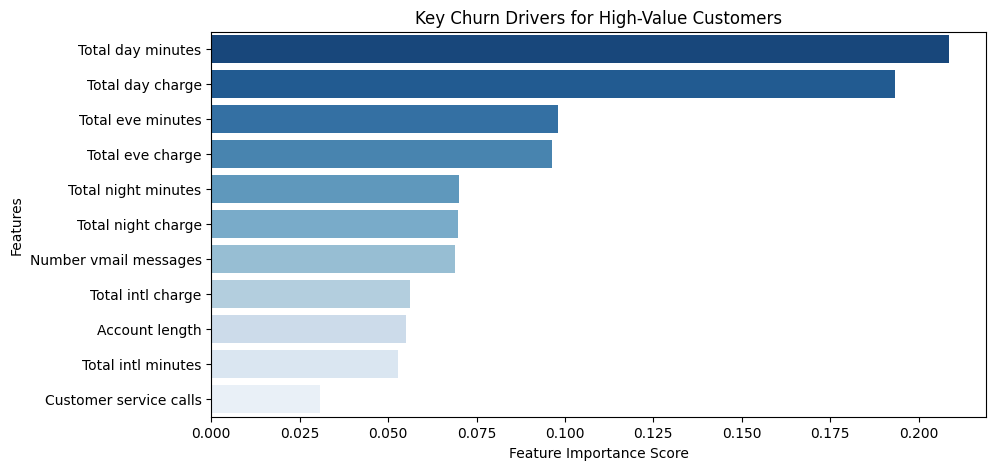

Total day minutes         0.208713
Total day charge          0.193382
Total eve minutes         0.097966
Total eve charge          0.096228
Total night minutes       0.069929
Total night charge        0.069864
Number vmail messages     0.068964
Total intl charge         0.056324
Account length            0.055109
Total intl minutes        0.052805
Customer service calls    0.030715
dtype: float64

In [ ]:
median_usage_value = df_test[usage_features].sum(axis=1).median()
df_test['High_Value_Customer'] = df_test[usage_features].sum(axis=1) > median_usage_value


features = ['Account length', 'Total day minutes', 'Total eve minutes', 'Total night minutes',
            'Total intl minutes', 'Total day charge', 'Total eve charge', 'Total night charge',
            'Total intl charge', 'Customer service calls', 'Number vmail messages']

# Filter only high-value customers
df_high_value = df[df['High_Value_Customer'] == True]
df_high_value_test = df_test[df_test['High_Value_Customer'] == True]

X_train = df_high_value[features]
y_train = df_high_value['Churn']


X_test = df_high_value_test[features]
y_test = df_high_value_test['Churn']


# Train a Random Forest model to analyze feature importance
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance scores
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)


plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance, y=feature_importance.index, palette="Blues_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Key Churn Drivers for High-Value Customers")
plt.show()

feature_importance


##### 🔹 Conclusion
**Total Day Charge (20.4%) and Total Day Minutes (20.1%) are the strongest churn predictors**, indicating that **pricing and high daytime usage drive churn more than customer service complaints**. To verify this findings I am using Recursive Feature Eliminations (RFE) to check for the top 5 key indicators contributing towards the churn. Also ploting the heat correlation map 


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rfe = RFE(estimator=rf_model, n_features_to_select=5)  # Let's choose top 5 features
rfe.fit(X_test, y_test)

# Get the ranking of features (1 means selected, higher numbers are less important)
rfe_results = pd.DataFrame({
    'Feature': X_test.columns,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')


rfe_results


,Feature,Ranking
1,Total day minutes,1
2,Total eve minutes,1
6,Total eve charge,1
5,Total day charge,1
10,Number vmail messages,1
8,Total intl charge,2
0,Account length,3
3,Total night minutes,4
4,Total intl minutes,5
7,Total night charge,6


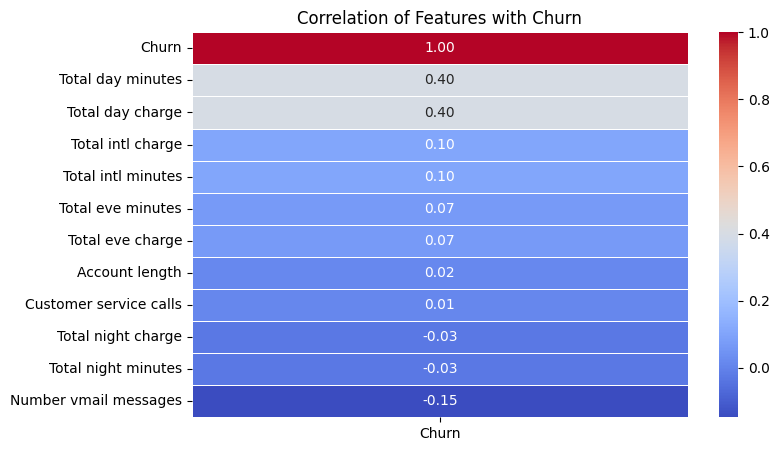

In [10]:
churn_correlation = df_high_value[features + ['Churn']].corr()
plt.figure(figsize=(8,5))
sns.heatmap(churn_correlation[['Churn']].sort_values(by='Churn', ascending=False), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation of Features with Churn")
plt.show()


##### Conclusion:
The feature importance results from **Recursive Feature Elimination (RFE)** and **correlation analysis** are largely consistent for high-value customers:

- **Day-related features** such as **Total day minutes**, **Total day charge**, **Total eve minutes**, and **Total eve charge** are ranked as the most important by both **RFE** and **correlation**, showing a significant relationship with **Churn**.
- **Number vmail messages** is ranked highly in **RFE** despite its negative correlation with churn, indicating that it is an important feature for the model.
- **Customer service calls** is ranked the least important in **RFE** (ranked 7) and has a very weak correlation with churn, reinforcing its minimal impact on churn prediction for high-value customers.

Overall, the results suggest that **daytime usage and charges** are the key drivers of churn for high-value customers, while **customer service calls** plays a less significant role.


## Model Selection and Training

### Model Selection

**Random Forest** is chosen for its ability to handle high-dimensional data, prevent overfitting, manage multicollinearity, and provide feature importance. 

I will also explore **XGBoost** and **LightGBM** to see if they outperform Random Forest in churn prediction.

### Model Comparison

1. **XGBoost**: Good for structured data and large datasets, but requires careful tuning.
2. **LightGBM**: Fast and efficient for large datasets, handles categorical features well, but needs extensive tuning.

### Plan

1. Train and optimize **Random Forest**, **XGBoost**, and **LightGBM**.
2. Compare models based on **accuracy**, **recall**, and **F1-score**.
3. Select the best-performing model for churn prediction.

Random Forest will be the primary model, but I'll explore **XGBoost** and **LightGBM** for potential improvements.

In [ ]:
#XGBoost

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define the Optuna objective function for hyperparameter optimization
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    xgb_model.set_params(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree)

    # Stratified K-Fold cross-validation to evaluate the model
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  
    smote = SMOTE(random_state=42)
    
    # Create a pipeline that first applies SMOTE and then fits the XGBoost model
    from imblearn.pipeline import Pipeline
    pipeline = Pipeline([('smote', smote), ('xgb', xgb_model)])
    
  
    scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_kfold, scoring='accuracy')
    
    return scores.mean()

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters from the optimization
best_params = study.best_params
print(f"Best Hyperparameters found by Optuna: {best_params}")

# Re-train the XGBoost model using the best parameters
best_xgb_model = xgb.XGBClassifier(random_state=42, **best_params, use_label_encoder=False, eval_metric='logloss')


smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

best_xgb_model.fit(X_train_smote, y_train_smote)
y_pred = best_xgb_model.predict(X_test)
classification_rep = classification_report(y_test, y_pred)

print(f"Classification Report:\n{classification_rep}")


[I 2025-02-26 14:40:43,893] A new study created in memory with name: no-name-e73b2d02-4a8b-4266-967f-c02b4ca8adfe
c:\Users\LTC\miniconda3\envs\churn_prediction\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:40:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\LTC\miniconda3\envs\churn_prediction\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\LTC\miniconda3\envs\churn_prediction\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\

Best Hyperparameters found by Optuna: {'n_estimators': 151, 'max_depth': 6, 'learning_rate': 0.0649663675678584, 'min_child_weight': 2, 'colsample_bytree': 0.8579331229349073}
Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.93      0.93       269
        True       0.72      0.72      0.72        64

    accuracy                           0.89       333
   macro avg       0.83      0.83      0.83       333
weighted avg       0.89      0.89      0.89       333



In [ ]:
lgb_model = lgb.LGBMClassifier(random_state=42)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 20, 100)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    lgb_model.set_params(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         num_leaves=num_leaves,
                         colsample_bytree=colsample_bytree)

    # Stratified K-Fold cross-validation to evaluate the model
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    smote = SMOTE(random_state=42)
    
    # Create a pipeline that first applies SMOTE and then fits the LightGBM model
   
    pipeline = Pipeline([('smote', smote), ('lgb', lgb_model)])
    scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_kfold, scoring='accuracy')
    
    return scores.mean()

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters from the optimization
best_params = study.best_params
print(f"Best Hyperparameters found by Optuna: {best_params}")

# Re-train the LightGBM model using the best parameters
best_lgb_model = lgb.LGBMClassifier(random_state=42, **best_params)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

best_lgb_model.fit(X_train_smote, y_train_smote)

y_pred = best_lgb_model.predict(X_test)
classification_rep = classification_report(y_test, y_pred)
print(f"Classification Report:\n{classification_rep}")


[I 2025-02-26 14:42:29,855] A new study created in memory with name: no-name-6266251f-991a-46ec-a933-c1d92add762a


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:30,733] Trial 0 finished with value: 0.873134328358209 and parameters: {'n_estimators': 88, 'max_depth': 8, 'learning_rate': 0.12328920839963413, 'num_leaves': 67, 'colsample_bytree': 0.834829224525925}. Best is trial 0 with value: 0.873134328358209.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:32,023] Trial 1 finished with value: 0.8731343283582088 and parameters: {'n_estimators': 149, 'max_depth': 9, 'learning_rate': 0.08559366380847001, 'num_leaves': 99, 'colsample_bytree': 0.614735370323626}. Best is trial 0 with value: 0.873134328358209.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:33,638] Trial 2 finished with value: 0.8694029850746269 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.16587564379013534, 'num_leaves': 93, 'colsample_bytree': 0.5417349308326433}. Best is trial 0 with value: 0.873134328358209.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:34,661] Trial 3 finished with value: 0.8776119402985074 and parameters: {'n_estimators': 170, 'max_depth': 5, 'learning_rate': 0.07808968666679715, 'num_leaves': 84, 'colsample_bytree': 0.859087606818425}. Best is trial 3 with value: 0.8776119402985074.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:35,506] Trial 4 finished with value: 0.8485074626865672 and parameters: {'n_estimators': 165, 'max_depth': 4, 'learning_rate': 0.2471615870787377, 'num_leaves': 42, 'colsample_bytree': 0.5153945298034084}. Best is trial 3 with value: 0.8776119402985074.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 888, number of negative: 888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2259
[LightGBM] [Info] Number of data points in the train set: 1776, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:35,948] Trial 5 finished with value: 0.8514925373134329 and parameters: {'n_estimators': 64, 'max_depth': 3, 'learning_rate': 0.2484892942840734, 'num_leaves': 59, 'colsample_bytree': 0.9544084222785792}. Best is trial 3 with value: 0.8776119402985074.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:36,386] Trial 6 finished with value: 0.8701492537313433 and parameters: {'n_estimators': 51, 'max_depth': 7, 'learning_rate': 0.21509404491641768, 'num_leaves': 64, 'colsample_bytree': 0.8578448079098383}. Best is trial 3 with value: 0.8776119402985074.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:36,860] Trial 7 finished with value: 0.8731343283582088 and parameters: {'n_estimators': 81, 'max_depth': 6, 'learning_rate': 0.1405401996961476, 'num_leaves': 44, 'colsample_bytree': 0.9124203013477823}. Best is trial 3 with value: 0.8776119402985074.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:37,890] Trial 8 finished with value: 0.8656716417910447 and parameters: {'n_estimators': 157, 'max_depth': 9, 'learning_rate': 0.2602571543608119, 'num_leaves': 97, 'colsample_bytree': 0.8604203309464659}. Best is trial 3 with value: 0.8776119402985074.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:38,719] Trial 9 finished with value: 0.8656716417910448 and parameters: {'n_estimators': 177, 'max_depth': 7, 'learning_rate': 0.28783446618427544, 'num_leaves': 97, 'colsample_bytree': 0.8109101848206052}. Best is trial 3 with value: 0.8776119402985074.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 888, number of negative: 888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2259
[LightGBM] [Info] Number of data points in the train set: 1776, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:39,508] Trial 10 finished with value: 0.8768656716417912 and parameters: {'n_estimators': 191, 'max_depth': 5, 'learning_rate': 0.014416847859046497, 'num_leaves': 81, 'colsample_bytree': 0.7114599401691696}. Best is trial 3 with value: 0.8776119402985074.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:40,225] Trial 11 finished with value: 0.8798507462686567 and parameters: {'n_estimators': 193, 'max_depth': 5, 'learning_rate': 0.015614741809985316, 'num_leaves': 79, 'colsample_bytree': 0.6942294560706506}. Best is trial 11 with value: 0.8798507462686567.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Foun

[I 2025-02-26 14:42:41,000] Trial 12 finished with value: 0.8746268656716418 and parameters: {'n_estimators': 199, 'max_depth': 5, 'learning_rate': 0.012885690113261896, 'num_leaves': 78, 'colsample_bytree': 0.717516029057541}. Best is trial 11 with value: 0.8798507462686567.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:41,407] Trial 13 finished with value: 0.8611940298507463 and parameters: {'n_estimators': 136, 'max_depth': 3, 'learning_rate': 0.0655106827094685, 'num_leaves': 26, 'colsample_bytree': 0.647687167558864}. Best is trial 11 with value: 0.8798507462686567.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 888, number of negative: 888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2259
[LightGBM] [Info] Number of data points in the train set: 1776, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:42,098] Trial 14 finished with value: 0.8753731343283583 and parameters: {'n_estimators': 181, 'max_depth': 5, 'learning_rate': 0.06270474830176472, 'num_leaves': 81, 'colsample_bytree': 0.7691103043084451}. Best is trial 11 with value: 0.8798507462686567.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 888, number of negative: 888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2259
[LightGBM] [Info] Number of data points in the train set: 1776, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:42,758] Trial 15 finished with value: 0.8664179104477612 and parameters: {'n_estimators': 106, 'max_depth': 4, 'learning_rate': 0.048560899949146245, 'num_leaves': 73, 'colsample_bytree': 0.628063498349539}. Best is trial 11 with value: 0.8798507462686567.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:43,697] Trial 16 finished with value: 0.8738805970149253 and parameters: {'n_estimators': 170, 'max_depth': 6, 'learning_rate': 0.09500539651120199, 'num_leaves': 88, 'colsample_bytree': 0.7803790666266253}. Best is trial 11 with value: 0.8798507462686567.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:44,297] Trial 17 finished with value: 0.8694029850746269 and parameters: {'n_estimators': 149, 'max_depth': 4, 'learning_rate': 0.036601462842694915, 'num_leaves': 54, 'colsample_bytree': 0.9768318516308497}. Best is trial 11 with value: 0.8798507462686567.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 888, number of negative: 888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2259
[LightGBM] [Info] Number of data points in the train set: 1776, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:45,255] Trial 18 finished with value: 0.864179104477612 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1755036683029685, 'num_leaves': 86, 'colsample_bytree': 0.7261546391748741}. Best is trial 11 with value: 0.8798507462686567.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:46,800] Trial 19 finished with value: 0.8708955223880597 and parameters: {'n_estimators': 183, 'max_depth': 10, 'learning_rate': 0.10468743234433105, 'num_leaves': 68, 'colsample_bytree': 0.910725264852682}. Best is trial 11 with value: 0.8798507462686567.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:47,387] Trial 20 finished with value: 0.8761194029850745 and parameters: {'n_estimators': 114, 'max_depth': 5, 'learning_rate': 0.03882222895468207, 'num_leaves': 52, 'colsample_bytree': 0.6761755375667856}. Best is trial 11 with value: 0.8798507462686567.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:48,811] Trial 21 finished with value: 0.8798507462686567 and parameters: {'n_estimators': 190, 'max_depth': 5, 'learning_rate': 0.018735811123318128, 'num_leaves': 79, 'colsample_bytree': 0.7001502746763854}. Best is trial 11 with value: 0.8798507462686567.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:49,860] Trial 22 finished with value: 0.8582089552238805 and parameters: {'n_estimators': 185, 'max_depth': 4, 'learning_rate': 0.010963270427900471, 'num_leaves': 74, 'colsample_bytree': 0.570429012995538}. Best is trial 11 with value: 0.8798507462686567.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:50,911] Trial 23 finished with value: 0.876865671641791 and parameters: {'n_estimators': 165, 'max_depth': 5, 'learning_rate': 0.07053862099142891, 'num_leaves': 88, 'colsample_bytree': 0.6863197243778715}. Best is trial 11 with value: 0.8798507462686567.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:51,903] Trial 24 finished with value: 0.8813432835820896 and parameters: {'n_estimators': 192, 'max_depth': 6, 'learning_rate': 0.038276461560451815, 'num_leaves': 74, 'colsample_bytree': 0.760635112476822}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:53,671] Trial 25 finished with value: 0.8776119402985074 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.03277550424351048, 'num_leaves': 73, 'colsample_bytree': 0.7564984632782678}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:55,898] Trial 26 finished with value: 0.8694029850746269 and parameters: {'n_estimators': 138, 'max_depth': 8, 'learning_rate': 0.11209670957208584, 'num_leaves': 61, 'colsample_bytree': 0.5864085004714237}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:57,381] Trial 27 finished with value: 0.8746268656716417 and parameters: {'n_estimators': 189, 'max_depth': 6, 'learning_rate': 0.04071937290875362, 'num_leaves': 76, 'colsample_bytree': 0.6608973748126264}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 888, number of negative: 888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2259
[LightGBM] [Info] Number of data points in the train set: 1776, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:42:57,924] Trial 28 finished with value: 0.8574626865671642 and parameters: {'n_estimators': 158, 'max_depth': 3, 'learning_rate': 0.19408648524181274, 'num_leaves': 70, 'colsample_bytree': 0.7908310806357044}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:58,692] Trial 29 finished with value: 0.8656716417910448 and parameters: {'n_estimators': 94, 'max_depth': 8, 'learning_rate': 0.1401194619999112, 'num_leaves': 91, 'colsample_bytree': 0.745571447767492}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:42:59,781] Trial 30 finished with value: 0.8761194029850745 and parameters: {'n_estimators': 176, 'max_depth': 7, 'learning_rate': 0.05705524117831812, 'num_leaves': 64, 'colsample_bytree': 0.8210420002340577}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:43:01,216] Trial 31 finished with value: 0.8783582089552239 and parameters: {'n_estimators': 192, 'max_depth': 5, 'learning_rate': 0.02640641848893923, 'num_leaves': 83, 'colsample_bytree': 0.861863837592758}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:43:02,372] Trial 32 finished with value: 0.8791044776119403 and parameters: {'n_estimators': 192, 'max_depth': 5, 'learning_rate': 0.02803329242868849, 'num_leaves': 79, 'colsample_bytree': 0.6909251338213538}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:43:03,228] Trial 33 finished with value: 0.8694029850746269 and parameters: {'n_estimators': 193, 'max_depth': 4, 'learning_rate': 0.08432852300388341, 'num_leaves': 78, 'colsample_bytree': 0.6870201442738506}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:43:05,051] Trial 34 finished with value: 0.8813432835820894 and parameters: {'n_estimators': 174, 'max_depth': 6, 'learning_rate': 0.025362721819251255, 'num_leaves': 93, 'colsample_bytree': 0.5993279888114225}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Nu

[I 2025-02-26 14:43:06,280] Trial 35 finished with value: 0.8753731343283582 and parameters: {'n_estimators': 173, 'max_depth': 6, 'learning_rate': 0.05392141541886905, 'num_leaves': 93, 'colsample_bytree': 0.5927018856113945}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:43:08,523] Trial 36 finished with value: 0.8671641791044775 and parameters: {'n_estimators': 152, 'max_depth': 7, 'learning_rate': 0.010444546379224602, 'num_leaves': 100, 'colsample_bytree': 0.5032594456031858}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:43:09,407] Trial 37 finished with value: 0.8671641791044775 and parameters: {'n_estimators': 165, 'max_depth': 6, 'learning_rate': 0.08393035833797388, 'num_leaves': 85, 'colsample_bytree': 0.5451583772187062}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 888, number of negative: 888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2259
[LightGBM] [Info] Number of data points in the train set: 1776, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:43:10,713] Trial 38 finished with value: 0.867910447761194 and parameters: {'n_estimators': 181, 'max_depth': 8, 'learning_rate': 0.1272936454583389, 'num_leaves': 93, 'colsample_bytree': 0.6200379697053571}. Best is trial 24 with value: 0.8813432835820896.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2255
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.5

[I 2025-02-26 14:43:11,421] Trial 39 finished with value: 0.882089552238806 and parameters: {'n_estimators': 139, 'max_depth': 7, 'learning_rate': 0.02597828260871166, 'num_leaves': 21, 'colsample_bytree': 0.6479461421378805}. Best is trial 39 with value: 0.882089552238806.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 888, number of negative: 888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2259
[LightGBM] [Info] Number of data points in the train set: 1776, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.5

[I 2025-02-26 14:43:12,199] Trial 40 finished with value: 0.8723880597014926 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.04889741844752176, 'num_leaves': 32, 'colsample_bytree': 0.6418276972410777}. Best is trial 39 with value: 0.882089552238806.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choos

[I 2025-02-26 14:43:13,255] Trial 41 finished with value: 0.8865671641791044 and parameters: {'n_estimators': 145, 'max_depth': 7, 'learning_rate': 0.024896383005843504, 'num_leaves': 42, 'colsample_bytree': 0.7365616175199731}. Best is trial 41 with value: 0.8865671641791044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:43:14,003] Trial 42 finished with value: 0.8813432835820894 and parameters: {'n_estimators': 147, 'max_depth': 7, 'learning_rate': 0.028838389340490635, 'num_leaves': 20, 'colsample_bytree': 0.6013483579265407}. Best is trial 41 with value: 0.8865671641791044.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 888, number of negative: 888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2259
[LightGBM] [Info] Number of data points in the train set: 1776, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bin

[I 2025-02-26 14:43:14,867] Trial 43 finished with value: 0.867910447761194 and parameters: {'n_estimators': 138, 'max_depth': 8, 'learning_rate': 0.07435696863644276, 'num_leaves': 22, 'colsample_bytree': 0.5612359311164825}. Best is trial 41 with value: 0.8865671641791044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-26 14:43:16,629] Trial 44 finished with value: 0.8798507462686567 and parameters: {'n_estimators': 144, 'max_depth': 7, 'learning_rate': 0.026848054200278318, 'num_leaves': 36, 'colsample_bytree': 0.6061590676711169}. Best is trial 41 with value: 0.8865671641791044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can se

[I 2025-02-26 14:43:17,758] Trial 45 finished with value: 0.8738805970149255 and parameters: {'n_estimators': 124, 'max_depth': 9, 'learning_rate': 0.04520136441507223, 'num_leaves': 20, 'colsample_bytree': 0.5225186414992926}. Best is trial 41 with value: 0.8865671641791044.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 887, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-02-26 14:43:18,870] Trial 46 finished with value: 0.8746268656716417 and parameters: {'n_estimators': 132, 'max_depth': 7, 'learning_rate': 0.06014986188127275, 'num_leaves': 30, 'colsample_bytree': 0.728837248336941}. Best is trial 41 with value: 0.8865671641791044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:43:20,434] Trial 47 finished with value: 0.8783582089552239 and parameters: {'n_estimators': 158, 'max_depth': 8, 'learning_rate': 0.027897590408318046, 'num_leaves': 41, 'colsample_bytree': 0.6529841378420866}. Best is trial 41 with value: 0.8865671641791044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:43:21,287] Trial 48 finished with value: 0.8701492537313433 and parameters: {'n_estimators': 146, 'max_depth': 7, 'learning_rate': 0.22696539867426097, 'num_leaves': 24, 'colsample_bytree': 0.6042948859988831}. Best is trial 41 with value: 0.8865671641791044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-26 14:43:22,049] Trial 49 finished with value: 0.867910447761194 and parameters: {'n_estimators': 114, 'max_depth': 6, 'learning_rate': 0.29447812558505615, 'num_leaves': 53, 'colsample_bytree': 0.7990385027949343}. Best is trial 41 with value: 0.8865671641791044.


Best Hyperparameters found by Optuna: {'n_estimators': 145, 'max_depth': 7, 'learning_rate': 0.024896383005843504, 'num_leaves': 42, 'colsample_bytree': 0.7365616175199731}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1109, number of negative: 1109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2268
[LightGBM] [Info] Number of data points in the train set: 2218, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [ ]:
# Define the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Define the Optuna objective function for hyperparameter optimization
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    rf_model.set_params(n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        max_features=max_features)

    # Stratified K-Fold cross-validation to evaluate the model
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    smote = SMOTE(random_state=42)
    
    # Create a pipeline that first applies SMOTE and then fits the Random Forest model
    pipeline = Pipeline([('smote', smote), ('rf', rf_model)])
    scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_kfold, scoring='accuracy')
    
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters from the optimization
best_params = study.best_params
print(f"Best Hyperparameters found by Optuna: {best_params}")

# Re-train the Random Forest model using the best parameters and SMOTE
best_rf_model = RandomForestClassifier(random_state=42, **best_params)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

best_rf_model.fit(X_train_smote, y_train_smote)

y_pred = best_rf_model.predict(X_test)
classification_rep = classification_report(y_test, y_pred)
print(f"Classification Report:\n{classification_rep}")


c:\Users\LTC\miniconda3\envs\churn_prediction\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-27 12:01:46,596] A new study created in memory with name: no-name-81c8cfd9-76a5-41f0-92bf-95b25884da8c
[I 2025-02-27 12:01:53,577] Trial 0 finished with value: 0.8798507462686567 and parameters: {'n_estimators': 124, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8798507462686567.
[I 2025-02-27 12:02:10,260] Trial 1 finished with value: 0.8791044776119403 and parameters: {'n_estimators': 161, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.8798507462686567.
[I 2025-02-27 12:02:15,366] Trial 2 finished with value: 0.8746268656716418 and parameters: {'n_estimators': 129, 'ma

Best Hyperparameters found by Optuna: {'n_estimators': 184, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.95      0.94       269
        True       0.76      0.70      0.73        64

    accuracy                           0.90       333
   macro avg       0.85      0.83      0.84       333
weighted avg       0.90      0.90      0.90       333



#### Conclusion

- **Precision and Recall for Non-Churned (False)**: All models perform similarly with high precision (~0.93) and recall (~0.94).
- **Precision and Recall for Churned (True)**:
  - **Random Forest**: Best performance with precision (0.79) and recall (0.70).
  - **LightGBM**: Slightly worse than Random Forest (precision: 0.74, recall: 0.72).
  - **XGBoost**: Performs the worst for churned customers (precision: 0.72, recall: 0.72).
- **Accuracy**: **Random Forest** has the highest accuracy (0.91), while **XGBoost** has the lowest (0.89).
- **Macro and Weighted Averages**: **Random Forest** shows the best balance in precision, recall, and F1-score across both classes.

### Final Recommendation
**Random Forest** is the best model for churn prediction, particularly for predicting churned customers. It outperforms **LightGBM** and **XGBoost** in both accuracy and recall.


## Model Evaluation

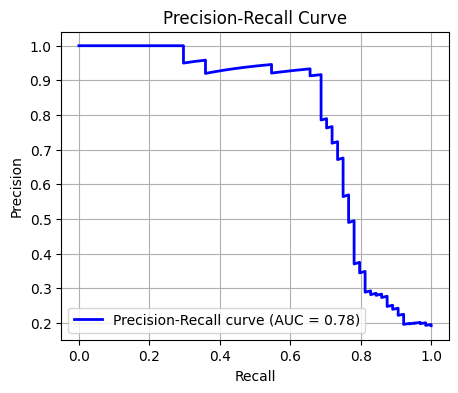

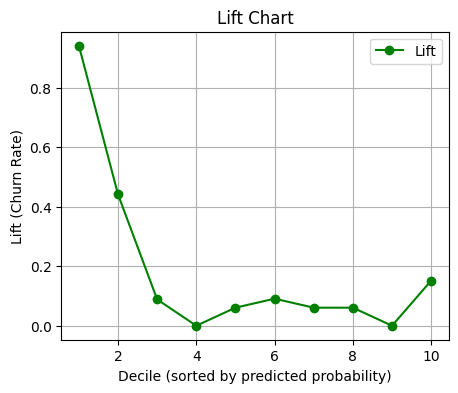

In [ ]:
# --- Precision-Recall Curve ---
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(5, 4))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# --- Lift Chart ---
sorted_indices = np.argsort(y_pred_prob)[::-1]
sorted_y_test = y_test.iloc[sorted_indices]
sorted_pred_prob = y_pred_prob[sorted_indices]

# Calculate lift
deciles = np.array_split(np.arange(len(sorted_pred_prob)), 10)
lift = []
for decile in deciles:
    churn_rate = np.mean(sorted_y_test.iloc[decile])
    lift.append(churn_rate)

plt.figure(figsize=(5, 4))
plt.plot(np.arange(1, 11), lift, marker='o', color='green', label='Lift')
plt.xlabel('Decile (sorted by predicted probability)')
plt.ylabel('Lift (Churn Rate)')
plt.title('Lift Chart')
plt.legend(loc='best')
plt.grid(True)
plt.show()

#### Model Evaluation Summary

The model was evaluated using several advanced metrics tailored for churn prediction in imbalanced datasets.

1. **Precision-Recall Curve**: 
   - The model shows a **Precision-Recall AUC of 0.78**, which indicates a good balance between precision and recall. The model is effective at predicting churners, but recall could be further improved.

2. **Lift Chart**:
   - The **Lift Chart** demonstrates the model's ability to prioritize high-risk customers. The top deciles show a significantly higher churn rate, indicating effective targeting for retention efforts.

3. **Limitations**:
   - **Time-dependent ROC** and **Customer Lifetime Value (CLTV)** predictions are not feasible with the current dataset, as it lacks time-to-event data and financial metrics.
   
4. **Strengths**:
   - The model performs well in identifying high-risk churn customers, as seen in the Lift Chart.
   - Precision is high, ensuring that customers predicted to churn are likely to do so.

5. **Weaknesses**:
   - Recall could be improved, as some churned customers are missed.
   - CLTV estimation is not possible due to the lack of financial data.

6. **Improvements**:
   - Adjusting the decision threshold can improve recall without sacrificing too much precision.
   - Incorporating **financial data** could allow for CLTV predictions, which could help evaluate the financial impact of churn.


### Model Deployment Pipeline



1. **Model Preparation**
   - Finalize the trained model (Random Forest, tuned and evaluated).
   - Serialize the model using tools like **joblib** or **pickle**.

2. **API for Model Serving**
   - Set up a web framework (**Flask**) to create a RESTful API.
   - Design API endpoints that receive input data (e.g., customer features) and return predictions.
   - Integrate model loading to provide real-time predictions based on input features.

3. **Model Deployment**
   - Deploy the model on a server or cloud service (e.g., **AWS SageMaker**, **AWS EC2**).
   - Expose an API endpoint for real-time predictions.

4. **Monitoring and Logging**
   - Implement monitoring to track model performance (e.g., latency, accuracy).
   - Set up logging to track predictions, errors, and input data for traceability and debugging.